### Nome: Samuel Felipe dos Santos

# PROJETO 1 – EXPERIMENTO MLP

Utilizar a rede MLP para:
<UL>
<LI>Realizar testes com 3(ou mais) datasets selecionados do repositório da UCI (iris, etc...) para várias configuração da rede;
<LI>Ilustrar graficamente o processo de aprendizagem pela redução do erro quadrático médio; 
<LI>Entregar um relatório descrevendo os experimentos. 
</UL>

Considerar:
<UL>
<LI>Impacto do termo de momentum
<LI>Impacto da regularização L2
</UL>

## Metodologia

### Bibliotecas utilizadas

Foi utilizada a linguagem de programação Python 3.0 em conjunto com a biblioteca Sklearn.

In [2]:
import numpy as np
from sklearn.datasets import load_iris, load_breast_cancer, fetch_california_housing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import dill
from IPython.display import HTML

### Datasets
Foram escolhidos os seguintes três datasets para avaliação dos resultados:
<UL>
<LI><b>Iris Dataset:</b> consiste de 50 amostras  de cada uma das 3 espécies da flor iris, que esta disponivel no pacote Sklearn;

<LI><b>Breast Cancer Wisconsin (Diagnostic) Dataset:</b> características computadas a partir de imagens biomédicas, e utilizadas para classificar se há câncer de mama, mais detalhes podem ser encontrados em 
<a href="https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)">https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)</a>. Foi utilizada a versão disponibilizada no pacote Sklearn;

<LI><b>Alcohol QCM Sensor Dataset Dataset:</b> consiste de amostras de álcool que podem ser classificadas em 5 tipos (1-octanol, 1-propanol, 2-butanol, 2-propanol, 1-isobutanol). Os atributos de cada amostra consistem de medições realizadas por sensores com diferentes configurações, que atribuidas sobre a amostra no formato de gás em diferentes concentrações. Foi utilizado a versão do dataset disponível em <a href="https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset">https://archive.ics.uci.edu/ml/datasets/Alcohol+QCM+Sensor+Dataset</a>, onde se encontram mais detalhes.
</UL>


### Pré-processamento dos dados

Inicialmente os dados são divididos em conjuntos de Treinamento (80% dos dados) e Validação (20%) de maneira estratificada, mantendo a proporção de classes do dataset original em cada conjunto.

In [53]:
def trainValSplit( X, Y, testSize=0.2, randomState=0 ):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=testSize, random_state=randomState)
    splits = sss.split(X, Y)    
    return splits

Os dados então são normalizados utilizando a função <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a> da biblioteca Sklearn, que realiza a seguinte operação:<br />
<br />
z = (x - u) / s<br />
<br />
Onde x é uma amostra, u é a média das amostras do treino e s o desvio padrão do treino.

In [52]:
def Normalize( X, train_index ):
    scaler = StandardScaler()
    scaler.fit(X[train_index])
    X = scaler.transform(X)
    return X

### Otimização de Hiperparâmetros da Rede

Foi utilizado a rede <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html">MLPClassifier</a> que utiliza a perda de <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html">entropia cruzada (Cross-entropy loss)</a>, sendo fixado o otimizador SGD. Foi utilizada a técnica de <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">Grid Search</a> disponível na biblioteca Sklearn, que realiza uma pesquisa exaustiva sobre os valores de hiperparâmetors especificados.<br /> 

Foram otimizados os seguintes hiperparâmetros:
<UL>

<LI><b>Camadas Ocultas:</b> foram testadas 1 e 2 camadas ocultas, podendo cada uma conter 25, 50, 75 ou 100 neuronios;

<LI><b>alpha:</b> parâmetro que indica a penalidade L2 (termo de regularização), sendo observado os valores de 0.0001, 0.00001, 0.000001, 0.0000001 e 0.0;

<LI><b>Taxa de aprendizado inicial:</b> Foram usados os valores de 0.0001, 0.0005, 0.001, 0.005 e 0.01;

<LI><b>Decaimento da taxa de aprendizado:</b> o decaimento dos pesos foi realizado de três maneiras:<br />
(1) <b>Constante:</b> onde não há decaimento;<br />
(2) <b>Invscaling:</b> a cada espaço de tempo t a taxa de aprendizado é dividida por pow(t, 0.5);<br />
(3) <b>Adaptativa:</b> a taxa de aprendizado é dividida por 5 quando o perda na validação não mehora por duas épocas consecutivas.   

<LI><b>Momentum:</b> foram utilizados os valores de 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 e 1.0.

</UL>

In [2]:
parameters = {
    'hidden_layer_sizes' :[(100), (75), (50), (25),
                           (100,100), (100,75), (100,50), (100,25),
                           ( 75,100), ( 75,75), ( 75,50), ( 75,25),
                           ( 50,100), ( 50,75), ( 50,50), ( 50,25),
                           ( 25,100), ( 25,75), ( 25,50), ( 25,25)],
    
    'activation' : ['relu'],
    'solver' : ['sgd'],
    'alpha' : [0.0001,0.00001, 0.000001, 0.0000001, 0.0],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init' : [0.0001, 0.0005, 0.001, 0.005, 0.01],
    'momentum' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

### Análise dos hiperperâmetros de Momentum e Regularização L2

Após serem encontrados os melhores hiperparâmetros para rede, esses são fixados, variando apenas o momentum e o alpha (termo da regularização L2), um de cada vez, sendo possível assim analisar o impacto de cada um.<br />
<br />
É observada a função de perda e a acurácia, para o conjunto de treinamento e validação ao final de cada época. O processo é repetido 10 vezes, sendo mostrado no final um gráfico com a média.


In [85]:
def generate_learning_curve(x, y, x_val, y_val, varying_parameter, classes = [0,1,2], momentum=1, lri=0.001, alpha=0.0001, hidden_layer_sizes=(100,100), regression=False):
    tables = []

    if regression == False:
        model = MLPClassifier
    else:
        model = MLPRegressor
    
    for p in parameters[varying_parameter]:
        dfs = []
        for i in range(10):

            if varying_parameter == 'momentum':
                mlp = model( hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd', alpha=alpha,
                             learning_rate= 'constant', learning_rate_init=lri, momentum=p, max_iter=1, warm_start=True)
            elif varying_parameter == 'alpha':    
                mlp = model( hidden_layer_sizes=(100,100), activation='relu', solver='sgd', alpha=p,
                             learning_rate= 'constant', learning_rate_init=lri, momentum=momentum, max_iter=1, warm_start=True)
            else:
                raise ValueError('input error')
            run_table = []
            for epoch in range(200):
                if regression == False:
                    mlp.partial_fit(x, y, classes = classes)
                else:
                    mlp.partial_fit(x, y)
                if regression == False:
                    pred = mlp.predict_proba(x_val)
                    loss_val = log_loss(y_val, pred)
                else:
                    pred = mlp.predict(x_val)
                    loss_val = mean_squared_error(y_val, pred)
                loss = mlp.loss_
                score = mlp.score(x, y)
                score_val = mlp.score(x_val, y_val)
                run_table += [[epoch, loss, loss_val, score, score_val]]

            dfs += [pd.DataFrame( data=run_table,  columns=['epochs', 'loss', 'loss_val', 'acc', 'acc_val'] )]
        tables += [pd.Panel({n: df for n, df in enumerate(dfs)}).mean(axis=0)]
    return tables

In [4]:
def plot_learning_curve(tables, params, colors, param_name):
    plt.rcParams['figure.figsize'] = [15, 10]
    f, axarr = plt.subplots(2, 2)
    fig = plt.figure(figsize=(10,5))
    i=0
    train_val = ['treino', 'validação']
    for i in range(len(tables)):
        axarr[0,0].plot(tables[i]['epochs'], tables[i]['acc'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[0,0].set_title('Treinamento', fontsize=25)
    axarr[0,0].set_xlabel('épocas')
    axarr[0,0].set_ylabel('acurácia', fontsize=25)

    for i in range(len(tables)):
        axarr[0,1].plot(tables[i]['epochs'], tables[i]['acc_val'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[0,1].set_title('Validação', fontsize=25)
    axarr[0,1].set_xlabel('épocas')

    for i in range(len(tables)):
        axarr[1,0].plot(tables[i]['epochs'], tables[i]['loss'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[1,0].set_xlabel('épocas')
    axarr[1,0].set_ylabel('perda', fontsize=25)

    for i in range(len(tables)):
        axarr[1,1].plot(tables[i]['epochs'], tables[i]['loss_val'], color=colors[i], label = param_name+'='+str(params[i]) )
    axarr[1,1].set_xlabel('épocas')


    f.subplots_adjust(hspace=0.3)

    axarr[0,0].legend(loc='upper left', bbox_to_anchor=(-0.1, 1.3), ncol=7)
    

## Resultados

### Dataset 1: Iris

In [12]:
def loadIris():
    iris = load_iris()
    return iris.data, iris.target
iris_X, iris_Y = loadIris()

In [54]:
iris_train_index, iris_val_index  = next(trainValSplit(iris_X,iris_Y))

In [6]:
scaler = StandardScaler()
scaler.fit(iris_X[iris_train_index])
iris_X = scaler.transform(iris_X)

In [ ]:
mlp = MLPClassifier()
gs = GridSearchCV(mlp, parameters, cv=trainValSplit(iris_X,iris_Y), n_jobs=8, verbose=10)
gs.fit(iris_X, iris_Y)

In [29]:
export_csv = iris_results.to_csv(r'results/iris_grid_search.csv', index = None, header=True)

Pode ser observado abaixo as 10 mehores configurações da rede encontradas pelo Grid Search, podendo ser obeservado que todas obtiveram 100% de acurácia no conjunto de validação e acurácias altas no de treino. De forma geral os melhores resultados foram obtidos com o parâmetro o maior valor testado para o parâmetro da regularição L2 testado, as camadas ocultas com maior quantidade de neurônios e os 2 valores de momentum mais altos.<br />

As taxas de aprendizado de 0.001, 0.005 e 0.01 aprezentaram resultados similares, assim como os metodos de decaimento constante e adaptativo.<br />

Esses resultados ocorreram possivelmente devido a se tratar de um dataset fácil, desse modo, a maioria das configurações do modelo obtiveram resultados satisfatórios.<br />

In [3]:
iris_results_table = pd.read_csv('results/iris_grid_search_sample.csv')
iris_results_table

,alpha,Camadas,Decaimento,lr,Momentum,Acc Validação,Acc Treino
0,0.0001,"(100, 100)",constant,0.001,1.0,1,0.975000
1,0.0001,"(100, 100)",constant,0.010,0.9,1,0.975000
2,0.0001,"(100, 100)",adaptive,0.010,0.9,1,0.975000
3,0.0001,"(100, 75)",constant,0.005,0.9,1,0.950000
4,0.0001,"(100, 75)",constant,0.010,0.9,1,0.966667
5,0.0001,"(100, 50)",constant,0.001,1.0,1,0.958333
6,0.0001,"(100, 50)",constant,0.010,0.9,1,0.966667
7,0.0001,"(100, 50)",adaptive,0.010,0.9,1,0.966667
8,0.0001,"(100, 25)",constant,0.010,0.9,1,0.966667
9,0.0001,"(100, 25)",adaptive,0.005,1.0,1,0.950000


Para a realização das próximas etapas, foi utilizado a rede com os seguintes parâmetros como base.

In [4]:
iris_results_table.loc[[0]]

,alpha,Camadas,Decaimento,lr,Momentum,Acc Validação,Acc Treino
0,0.0001,"(100, 100)",constant,0.001,1.0,1,0.975


Abaixo pode ser observada a <b>curva de aprendizado do Momentum para o melhor modelo encontrado</b>. De forma geral, é possível observar que quanto maior o valore de momentum, mais rápido a rede converge para uma perda menor e uma acurácia mais alta.

In [ ]:
m_tables = generate_learning_curve(iris_X[iris_train_index], iris_Y[iris_train_index], iris_X[iris_val_index], iris_Y[iris_val_index], 'momentum')

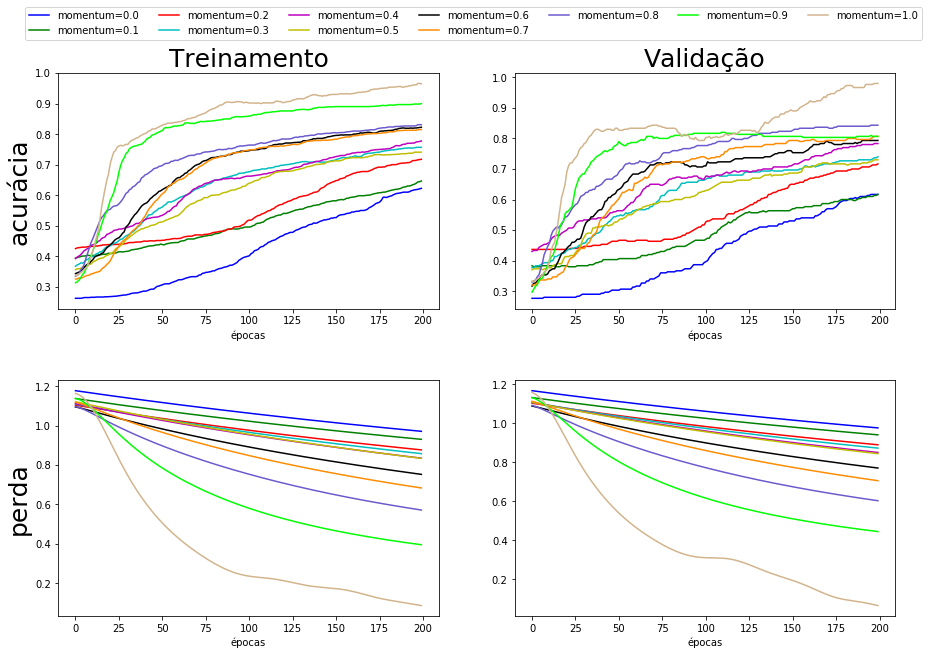

<Figure size 720x360 with 0 Axes>

In [13]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
plot_learning_curve(m_tables, parameters['momentum'], colors, 'momentum')

A <b>curva de aprendizado da Regularização L2 para o melhor modelo encontrado</b> representada a seguir mostra que não houve grande impacto do termo de regularização L2 (alpha) nos resultados.

In [ ]:
a_tables = generate_learning_curve(iris_X[iris_train_index], iris_Y[iris_train_index], iris_X[iris_val_index], iris_Y[iris_val_index], 'alpha')

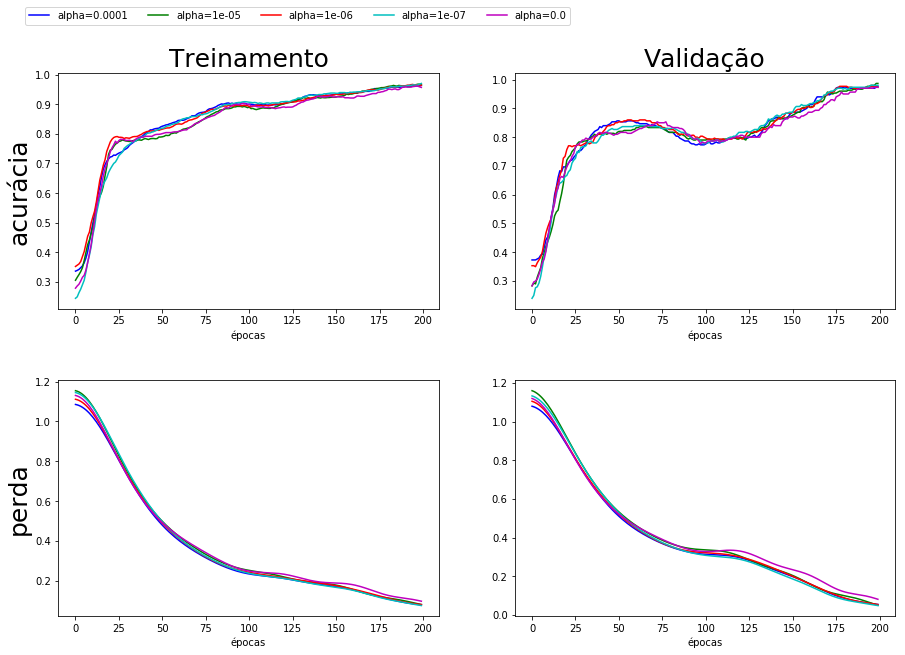

<Figure size 720x360 with 0 Axes>

In [129]:
plot_learning_curve(a_tables, parameters['alpha'], colors, 'alpha')

### Dataset 2:  breast cancer wisconsin dataset

In [41]:
def loadBCWD():
    BCWD = load_breast_cancer()
    return BCWD.data, BCWD.target
BCWD_X, BCWD_Y = loadBCWD()

In [55]:
BCWD_train_index, BCWD_val_index  = next(trainValSplit(BCWD_X,BCWD_Y))

In [44]:
scaler = StandardScaler()
scaler.fit(BCWD_X[BCWD_train_index])
BCWD_X = scaler.transform(BCWD_X)

In [ ]:
mlp = MLPClassifier()
gs = GridSearchCV(mlp, parameters, cv=trainValSplit(BCWD_X,BCWD_Y), n_jobs=-1, verbose=10)
gs.fit(BCWD_X, BCWD_Y)

In [ ]:
BCWD_results =pd.DataFrame.from_dict(gs.cv_results_)

In [48]:
export_csv = BCWD_results.to_csv(r'results/BCWD_grid_search.csv', index = None, header=True)

A tabela abaixo apresenta as configurações da rede com as melhores acurácias no conjunto de validação de de treinamento, onde, assim como no dataset anterior, foram obtidas acurácias altas (98,2456% na validação e próximo de 100% no treino). O parametors alpha e a quantidade de camadas não aparentam não afetar muito o resultado, já que foram obtidos resultados com desempenho bom com a maioria das combinações desses parâmetros. O decaimento constante e adaptativo se sairam melhor, assim como taxas de aprendizado entre 0.01 e 0.005 e momentum alto (entre 0.9 e 1).

In [5]:
BCWD_results_table = pd.read_csv('results/BCWD_grid_search_sample.csv')
BCWD_results_table

,alpha,Camadas,Decaimento,lr,Momentum,Acc Validação,Acc Treino
0,1.000000e-04,"(50, 100)",constant,0.010,0.9,0.982456,0.997802
1,0.000000e+00,"(25, 25)",constant,0.010,0.9,0.982456,0.997802
2,1.000000e-05,"(75, 100)",adaptive,0.010,1.0,0.982456,0.995604
3,1.000000e-06,"(25, 75)",constant,0.010,0.9,0.982456,0.995604
4,0.000000e+00,"(100, 25)",constant,0.005,0.9,0.982456,0.995604
5,0.000000e+00,"(75, 75)",constant,0.010,0.8,0.982456,0.995604
6,1.000000e-04,"(25, 75)",constant,0.010,0.8,0.982456,0.993407
7,1.000000e-04,"(25, 75)",adaptive,0.010,0.7,0.982456,0.993407
8,1.000000e-07,25,adaptive,0.010,0.9,0.982456,0.993407
9,1.000000e-07,"(50, 100)",adaptive,0.005,0.9,0.982456,0.993407


Para os experimentos variando o Momentum e o alpha, será considerada a configuração da rede a seguir como base.

In [6]:
BCWD_results_table.loc[[0]]

,alpha,Camadas,Decaimento,lr,Momentum,Acc Validação,Acc Treino
0,0.0001,"(50, 100)",constant,0.01,0.9,0.982456,0.997802


A <b>curva de aprendizado do Momentum para o melhor modelo encontrado</b> a seguir. Nela pode ser observado que no geral os resultados foram similares para diferentes valores de momentum, no entanto, os valores mais altos foram levemente melhores que os mais baixos.<br />
Olhando para função de perda no entanto, e possível verificar que para o valor mais alto possível de momentum (1.0) a perda aumenta muito no conjunto de treinamento indicando que pode estar ocorrendo sobreajuste.  

In [ ]:
BCWD_m_tables = generate_learning_curve(BCWD_X[BCWD_train_index], BCWD_Y[BCWD_train_index], BCWD_X[BCWD_val_index], BCWD_Y[BCWD_val_index], 'momentum', classes = [0,1], alpha=0.0001, momentum=0.9, hidden_layer_sizes=(50,100), lri=0.01)

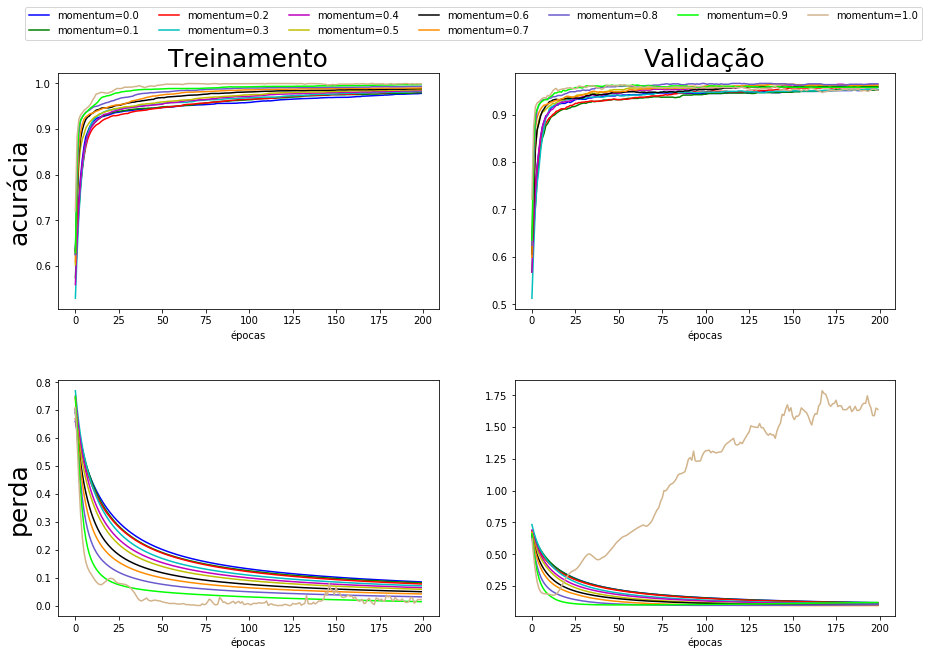

<Figure size 720x360 with 0 Axes>

In [87]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
plot_learning_curve(BCWD_m_tables, parameters['momentum'], colors, 'momentum')

Já para a <b>curva de aprendizado da Normalização L2 para o melhor modelo encontrado</b>, assim como no dataset Iris, o alpha não aparenta ter muita influência no resultado.

In [ ]:
BCWD_a_tables = generate_learning_curve(BCWD_X[BCWD_train_index], BCWD_Y[BCWD_train_index], BCWD_X[BCWD_val_index], BCWD_Y[BCWD_val_index], 'alpha', classes = [0,1], alpha=0.0001, momentum=0.9, hidden_layer_sizes=(50,100), lri=0.01)

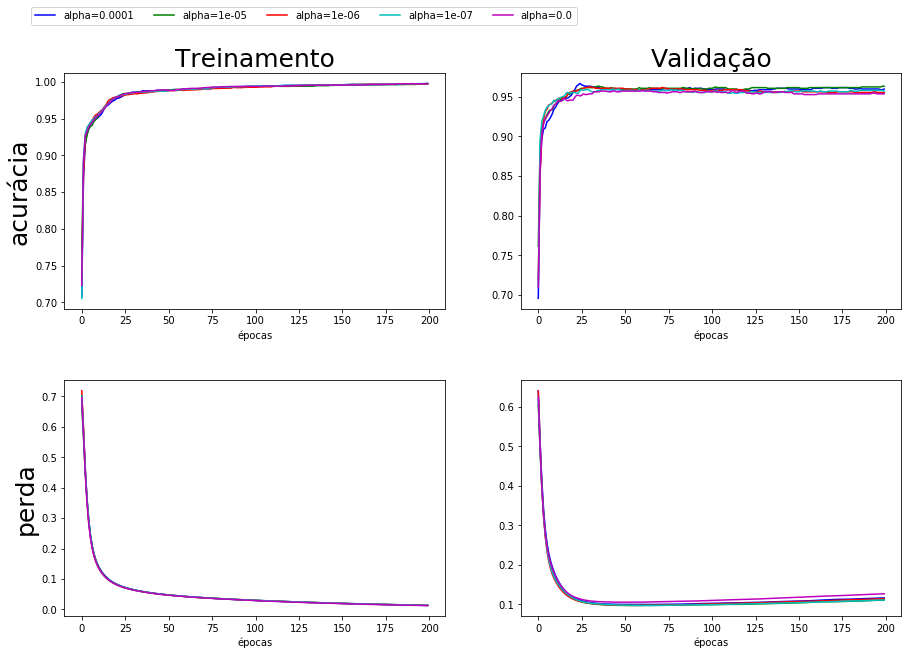

<Figure size 720x360 with 0 Axes>

In [89]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
plot_learning_curve(BCWD_a_tables, parameters['alpha'], colors, 'alpha')

### Dataset 3:  Alcohol QCM Sensor Dataset Data Set

In [17]:
def loadQCM():
    QCM3  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM3.csv', sep=';', header=0)
    QCM3['MIP'] = 1.0
    QCM3['NP']  = 1.0
    QCM6  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM6.csv', sep=';', header=0)
    QCM6['MIP'] = 1.0
    QCM6['NP']  = 0.0
    QCM7  = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM7.csv', sep=';', header=0)
    QCM7['MIP'] = 1.0
    QCM7['NP']  = 0.5
    QCM10 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM10.csv', sep=';', header=0)
    QCM10['MIP'] = 1.0
    QCM10['NP']  = 2.0
    QCM12 = pd.read_csv('datasets/QCM Sensor Alcohol Dataset/QCM12.csv', sep=';', header=0)
    QCM12['MIP'] = 0.0
    QCM12['NP']  = 1.0
    QCM = pd.concat([QCM3,QCM6,QCM7,QCM10,QCM12], ignore_index=True)
    QCM_X = np.concatenate( [np.array(QCM)[:,0:10], np.array(QCM)[:,15:17]], axis=1)
    QCM_Y_OneHot = np.array(QCM)[:,10:15]
    
    QCM_Y = np.zeros(len(QCM_Y_OneHot))
    for i in range(len(QCM_Y_OneHot)):
        for j in range(len(QCM_Y_OneHot[i])):
            if QCM_Y_OneHot[i,j] == 1:
                QCM_Y[i] = j
                break
    
    return QCM_X, QCM_Y
    
QCM_X, QCM_Y = loadQCM()

In [56]:
QCM_train_index, QCM_val_index  = next(trainValSplit(QCM_X, QCM_Y))

In [20]:
scaler = StandardScaler()
scaler.fit(QCM_X[QCM_train_index])
QCM_X = scaler.transform(QCM_X)

In [ ]:
mlp = MLPClassifier()
gs = GridSearchCV(mlp, parameters, cv=trainValSplit(QCM_X,QCM_Y), n_jobs=-1, verbose=10)
gs.fit(QCM_X, QCM_Y)

In [ ]:
QCM_results =pd.DataFrame.from_dict(gs.cv_results_)

In [40]:
export_csv = QCM_results.to_csv(r'results/QCM_grid_search.csv', index = None, header=True)

A tabela abaixo mostra os melhores resultados encontrados pelo Grid Search. Novamente foram encontrados diversas configurações da rede que atingiram o resultado máximo de acurácia para o treinamento e validação, sendo possível verificar que até mesmo a rede de uma camada obteve o resultdao máximo.

In [7]:
QCM_results_table = pd.read_csv('results/QCM_grid_search_sample.csv')
QCM_results_table

,alpha,Camadas,Decaimento,lr,momentum,Acc Validação,Acc Treino
0,0.0001,100,constant,0.005,1,1,1
1,0.0001,50,constant,0.010,1,1,1
2,0.0001,"(100, 75)",constant,0.005,1,1,1
3,0.0001,"(100, 75)",adaptive,0.005,1,1,1
4,0.0001,"(100, 50)",adaptive,0.005,1,1,1
5,0.0001,"(75, 100)",constant,0.010,1,1,1
6,0.0001,"(75, 75)",constant,0.005,1,1,1
7,0.0001,"(75, 50)",adaptive,0.005,1,1,1
8,0.0001,"(75, 50)",adaptive,0.010,1,1,1
9,0.0001,"(50, 75)",constant,0.010,1,1,1


Para os demais experimentos nesse dataset foi considerado a seguinte configuração da rede como base.

In [8]:
QCM_results_table.loc[[0]]

,alpha,Camadas,Decaimento,lr,momentum,Acc Validação,Acc Treino
0,0.0001,100,constant,0.005,1,1,1


A <b>curva de aprendizado do Momentum para o melhor modelo encontrado</b> é apresentada a seguir, podendo ser observado que o momentum teve uma grande influência no resultado, mostrando aumentos de desempenho significativos quando o valor desse era aumento.

In [ ]:
QCM_m_tables = generate_learning_curve(QCM_X[QCM_train_index], QCM_Y[QCM_train_index], QCM_X[QCM_val_index], QCM_Y[QCM_val_index], 'momentum', classes=[0,1,2,3,4], alpha=0.0001, hidden_layer_sizes=100, lri=0.005, momentum=1)

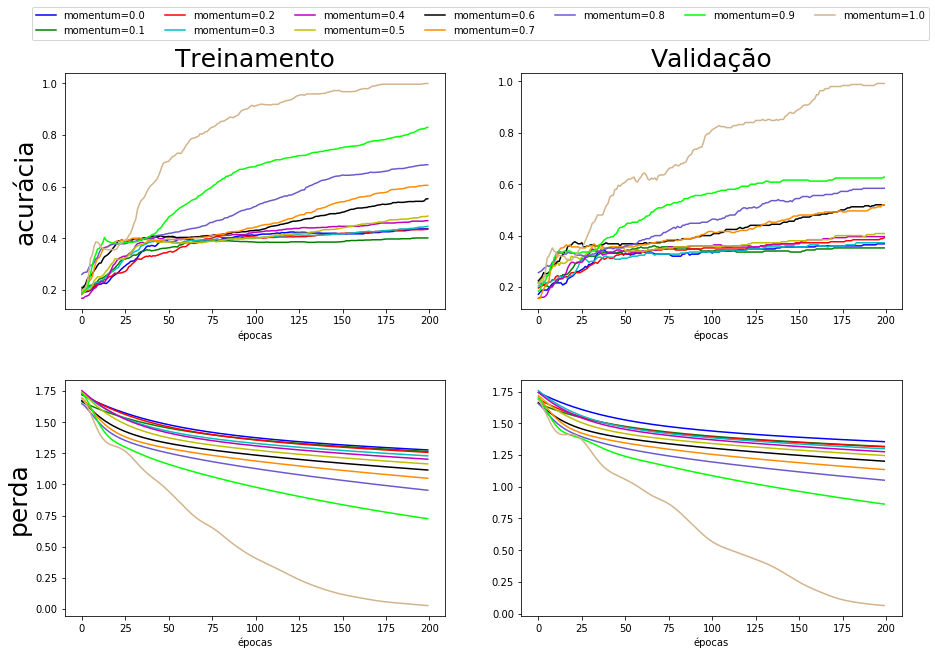

<Figure size 720x360 with 0 Axes>

In [94]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
plot_learning_curve(QCM_m_tables, parameters['momentum'], colors, 'momentum')

A <b>curva de aprendizado da normalização L2 para o melhor modelo encontrado</b> pode ser vista a seguir, onde novamente não foi obtida grandes diferenção nos resultados para diferentes valores de alpha.

In [ ]:
QCM_a_tables = generate_learning_curve(QCM_X[QCM_train_index], QCM_Y[QCM_train_index], QCM_X[QCM_val_index], QCM_Y[QCM_val_index], 'alpha', classes = [0,1,2,3,4], alpha=0.0001, hidden_layer_sizes=100, lri=0.005, momentum=1)

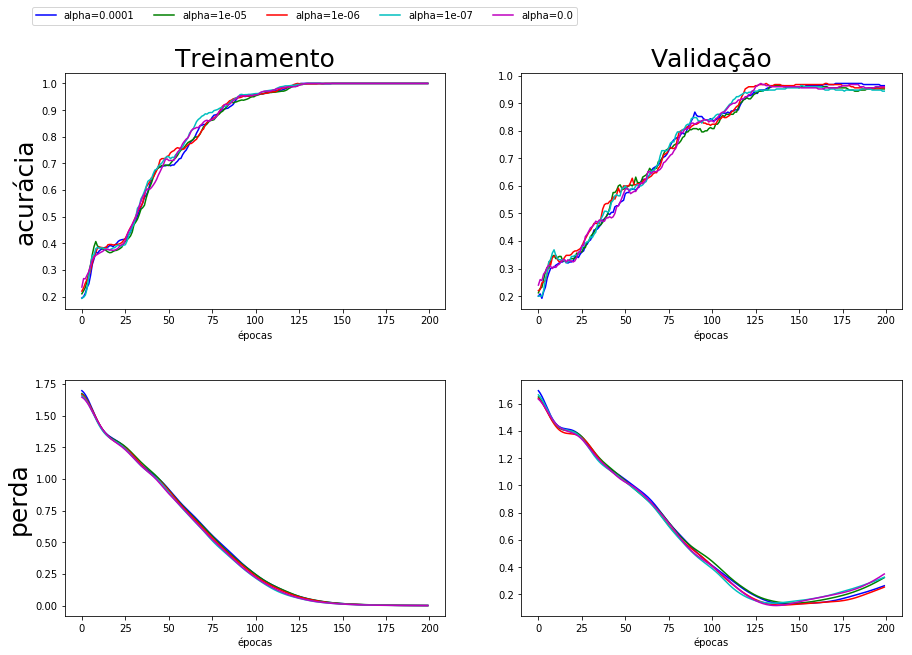

<Figure size 720x360 with 0 Axes>

In [97]:
colors = ['b','g','r','c','m','y','k','darkorange', 'slateblue', 'lime', 'tan']
plot_learning_curve(QCM_a_tables, parameters['alpha'], colors, 'alpha')

## Conclusão

Pode ser observado que para a maioria dos experimentos foi possível obter acurácia alta tanto para o conjunto de treinamento quanto o de validação para diversas configurações diferentes da rede. Acredito que isso se deve ao datasets escolhidos serem fáceis para o método sendo utilizado. Por esse motivo, alterações nos parâmetros como alpha e a quantidade de neurônios e camadas não apresentaram grandes diferenças de desempenho na rede.<br />

O aumento do momentum para os datasets Iris Dataset e o Alcohol QCM Sensor apresentou melhoria considerável no desempenho da rede, acredito que isso ocorra devido a pequena quantidade de dados nesses datasets (150 e 125 amostras, respectivamente), onde valores mais altos de momentum fazem com que os pesos sejam atualizados de maneira mais rápida, e dessa forma, conseguindo chegar em valores altos de acurácia rápido, mesmo com poucos dados.<br />

Pode ser observado que para a dataset Breast Cancer Wisconsin (Diagnostic), que é maior, possuindo 569 exemplos, o momentum teve uma importância um pouco menor apresentando resultados mais similares para diferentes vaores de momentum, mas ainda sim, valores mais altos se sairam melhor, com exceção do momentum=1.0 que apresentou sobre ajuste. 

